## Imports

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from datetime import datetime
import json
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, matthews_corrcoef, f1_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
import time
import sqlalchemy
from sklearn.manifold import TSNE
import seaborn as sns
import missingno
import requests
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
try:
  from github import Github
except:
  !pip install PyGithub
  from github import Github

     |████████████████████████████████| 215kB 2.8MB/s 


##  Relevant Functions

In [0]:
def plot_cm(y_true, y_pred, out_path=None, out_name=None, figsize=7):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    labels=list(set(y_true).union(set(y_pred)))
    ax = sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
    ax.set(ylabel='True Values', xlabel='Predicted Values')
    ax.set_yticklabels(rotation=0, labels=labels)
    if out_path:
        plt.savefig(os.path.join(out_path, out_name))
        
def create_scans_df(wifi_df):
    wifi_df_new = wifi_df.reset_index(drop=True)
    join_fields = list(wifi_df_new.columns)
    join_fields.remove('rssi_by_bssid')
    scans_df = pd.DataFrame.from_records(list(wifi_df_new['rssi_by_bssid'])).join(wifi_df_new[join_fields])
    scans_df['n_scans'] = scans_df.apply(lambda x: x.count()-2, axis=1)  # (-2) for columns 'room_id' and 'imei' in scans_df
    return scans_df

def preproccess(wifi_df, starting_date, keep_corridors=False):
    wifi_df = wifi_df.copy()
    wifi_df = wifi_df[wifi_df.timestamp > starting_date]
    wifi_df.drop(['roomId'],axis=1,inplace=True)
    wifi_df = wifi_df[wifi_df['rssi_by_bssid'] !={}]
    if not keep_corridors:
        wifi_df = wifi_df.dropna(subset=['room_id'])
    else:
        wifi_df['room_id'].fillna(0, inplace=True)
        wifi_df['room_id'] = wifi_df['room_id'].astype(int)

    #drop bad samples in room 42 of imei 87888aecf8b37f14  
    wifi_df = wifi_df[~((wifi_df['room_id'] == 42) & (wifi_df['imei'] == '87888aecf8b37f14'))]
    dum_cols = list(set(['manufacturer', 'android_version']).intersection(wifi_df.columns))
    dummies = pd.get_dummies(wifi_df[dum_cols])  
    wifi_df[list(dummies.columns)] = dummies    
    return wifi_df

### Parameters

In [0]:
fields_to_drop = ['altitude',
 'longitude',
 'latitude',
 'imei',
 'timestamp', 'manufacturer',
 'android_version', 'room_id']
fillna_rssi = -200
corridor = 0

In [28]:
# Fields to Drop
[column for column in scans_df.columns if ':' not in column]

['accuracy',
 'altitude',
 'longitude',
 'latitude',
 'imei',
 'timestamp',
 'room_id',
 'manufacturer',
 'android_version',
 'n_scans']

In [0]:
date_time = datetime.now().strftime("%m%d%Y_%H%M%S")
path = date_time + '_output_folder'
os.mkdir(path) #new output folder in main dir

## Reading the log files

##### make sure that the folder contains only log files

In [0]:
from getpass import getpass

In [8]:
user = 'tamar-ben-ami'
pas = getpass()

··········


In [0]:
g = Github(user, pas)
org = g.get_organization('hackorona')
repo = org.get_repo("HospiTrack")
contents = repo.get_contents("DataFiles")
url = 'https://raw.githubusercontent.com/hackorona/HospiTrack/master/DataFiles/{}'
urls = [url.format(content_file.name) for content_file in contents]

In [0]:
for url in urls:
  df = url_to_df(url)
  print(url)
  print(df.shape)
  print(df['imei'].unique())
  print(df.columns)

In [0]:
def check_json(row):
  try:
    return json.loads(row)
  except:
    return False
    
def url_to_df(url):
  txt = requests.get(url).text
  txt = txt.replace("}{", "}, {")
  data = txt.split(', ')
  return pd.DataFrame([json for json in list(map(check_json, data)) if json])

In [0]:
# def url_to_df(url):
#   txt = requests.get(url).text
#   txt = txt.replace("}{", "}, {")
#   data = txt.split(', ')
#   return pd.DataFrame([json.loads(row) for row in data if len(row) > 0])

In [0]:
wifi_df_orig = pd.concat([url_to_df(url) for url in urls])

In [0]:
th  = int(datetime.timestamp(datetime(2020, 4, 11, 9, 0, 0)))*1000

In [0]:
wifi_df = preproccess(wifi_df_orig, th)

In [43]:
print("Rooms for prediction : " + str(wifi_df.room_id.unique()))
print("Phones imeis : ")
imeis = list(wifi_df.imei.unique())
print(imeis)

Rooms for prediction : [51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68.
 69. 70.]
Phones imeis : 
['6a5c9cb42f6a70a', '7f8be5b0fba18340', '87888aecf8b37f14', '536b033fb2bafb79', '9308bd64741f2270', 'ef3f50e69df5ed94', '3549bf4f1277a712', '059a0413c81c9823', '504ffc12331cd426']


### Create scans dataframe

In [44]:
scans_df = create_scans_df(wifi_df)
print(scans_df.shape)
scans_df.head(2)

(22911, 618)


,56:d4:f7:52:37:ee,50:d4:f7:52:37:ee,18:d6:c7:91:9e:6e,74:da:88:0f:6b:41,04:f0:21:83:4c:0a,06:f0:21:83:4c:0a,30:24:78:c0:13:76,50:d4:f7:52:37:ef,e8:65:49:a5:dd:d0,e4:6f:13:6f:42:b6,80:e8:2c:02:46:2b,48:ee:0c:3a:9f:83,00:b8:c2:37:db:14,00:b8:c2:37:db:15,56:d4:f7:52:37:ef,02:cb:4e:43:88:05,14:ae:db:c0:77:8d,18:d6:c7:91:9e:6d,02:10:f3:63:a7:2a,00:10:f3:63:a7:2a,56:d4:f7:52:6e:7f,fc:15:b4:a7:5b:ed,9c:97:26:98:cb:c5,88:dc:96:4b:e6:ca,56:d4:f7:52:6e:7e,50:d4:f7:52:6e:7e,50:d4:f7:52:6e:7f,80:8d:b7:1c:56:e0,80:8d:b7:1c:56:e1,74:da:38:4d:10:a8,88:dc:96:4b:e9:9d,14:ae:db:50:8f:15,0c:b6:d2:e8:5b:99,70:4c:a5:fa:67:c0,c4:12:f5:fa:7d:f0,30:24:78:c0:13:77,14:59:c0:47:52:20,f4:f2:6d:f4:24:b2,d8:0d:17:70:e4:ea,7c:8b:ca:c5:50:8e,...,00:b8:c2:2d:c2:8b,b8:66:85:a9:0c:02,24:05:88:02:ab:79,94:bf:c4:3e:58:ac,d8:0d:17:a4:a0:b7,04:f0:21:4c:3c:22,08:97:58:32:8e:a6,98:da:c4:31:ff:6a,e4:7d:eb:2a:f5:06,18:7c:0b:1b:10:e8,90:6c:ac:dc:7b:bb,10:5a:f7:0d:00:04,e4:e7:49:70:c9:2f,98:9c:57:2b:b0:d6,f0:9f:c2:ee:d6:1e,78:8a:20:d7:ba:0b,c6:fb:e4:c8:d1:a2,b4:fb:e4:c8:d1:a2,b4:fb:e4:c7:d0:d6,accuracy,altitude,longitude,latitude,imei,timestamp,room_id,manufacturer,android_version,android_version_5.0,android_version_5.0.2,android_version_6.0,android_version_7.0,android_version_8.0.0,android_version_9,manufacturer_HUAWEI,manufacturer_LGE,manufacturer_Xiaomi,manufacturer_ZTE,manufacturer_samsung,n_scans
0,-63.0,-62.0,-68.0,-75.0,-81.0,-76.0,-79.0,-84.0,-71.0,-80.0,-80.0,-80.0,-79.0,-84.0,-84.0,-83.0,-81.0,-86.0,-85.0,-86.0,-90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6a5c9cb42f6a70a,1586680943530,51.0,LGE,6.0,0,0,1,0,0,0,0,1,0,0,0,35
1,-66.0,-66.0,-67.0,-76.0,-83.0,-82.0,-78.0,-84.0,-73.0,-79.0,NaN,-83.0,-80.0,-84.0,-81.0,-83.0,-82.0,-87.0,-85.0,NaN,-90.0,-82.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6a5c9cb42f6a70a,1586680946547,51.0,LGE,6.0,0,0,1,0,0,0,0,1,0,0,0,34


## Room prediction for each phone separately

In [45]:
scans_df['imei'].unique()

array(['6a5c9cb42f6a70a', '7f8be5b0fba18340', '87888aecf8b37f14',
       '536b033fb2bafb79', '9308bd64741f2270', 'ef3f50e69df5ed94',
       '3549bf4f1277a712', '059a0413c81c9823', '504ffc12331cd426'],
      dtype=object)

In [0]:
parameters = {'n_estimators': [50,100,200],
             'max_depth': [5,10,15],
             'criterion': ['gini', 'entropy'],
             'max_features': [10]} #[int(np.log2(X_train.shape[1])), int(np.sqrt(X_train.shape[1]))]

rf_cv = GridSearchCV(RandomForestClassifier(random_state=1), 
                   parameters, 
                   n_jobs = -1,
                   cv = 4,
                   refit = True)

kf = KFold(n_splits=4)
#                    scoring = 'f1')

In [0]:
models = {}

In [53]:
[column for column in X_train.columns if ':' not in column]

['accuracy',
 'room_id',
 'android_version_5.0',
 'android_version_5.0.2',
 'android_version_6.0',
 'android_version_7.0',
 'android_version_8.0.0',
 'android_version_9',
 'manufacturer_HUAWEI',
 'manufacturer_LGE',
 'manufacturer_Xiaomi',
 'manufacturer_ZTE',
 'manufacturer_samsung',
 'n_scans']

In [61]:
#results list
results = []
grid_search = True
nan_fill_value = -200

for imei in imeis:
    start = time.time()
    #train test split by imei:
    train = scans_df[scans_df['imei']!=imei]
    test = scans_df[scans_df['imei']==imei]

    X_train = train.drop(columns=fields_to_drop).fillna(fillna_rssi)
    X_test = test.drop(columns=fields_to_drop).fillna(fillna_rssi)
    y_train = train['room_id']
    y_test = test['room_id']
    
    if not grid_search:
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
    
    if grid_search:
        rf_cv.fit(X_train, y_train)
        rf = rf_cv.best_estimator_
        y_pred = rf.predict(X_test)
    
    #add the result to list
    models[imei] = {'X_train':X_train, 'X_test':X_test, 'y_train':y_train,'y_test':y_test, 'y_pred':y_pred, 'model':rf}
    results.append([y_test, y_pred])
    print(time.time()-start)


89.60735034942627
92.58243203163147
90.4028434753418
88.03203964233398
93.97855806350708
86.4071159362793
89.8377993106842
92.23102116584778
90.12252163887024


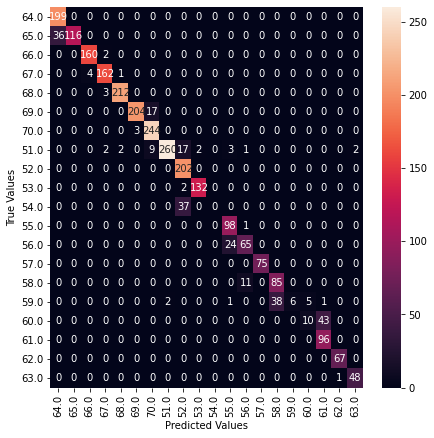

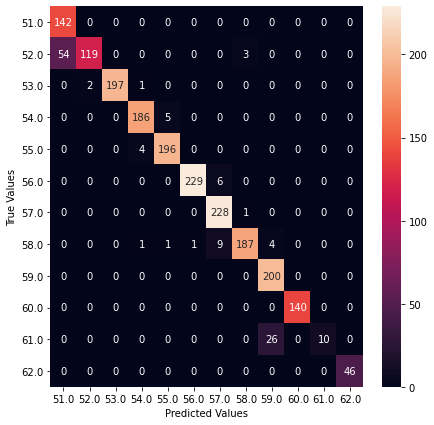

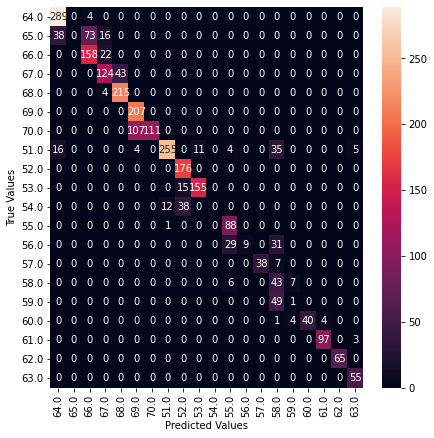

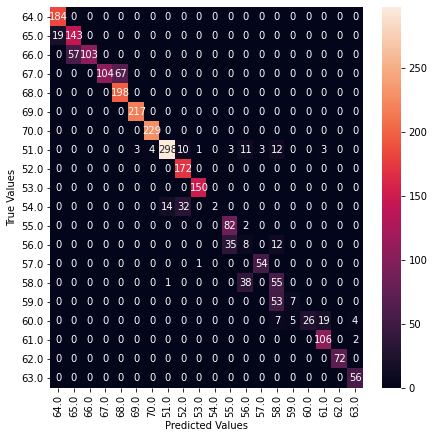

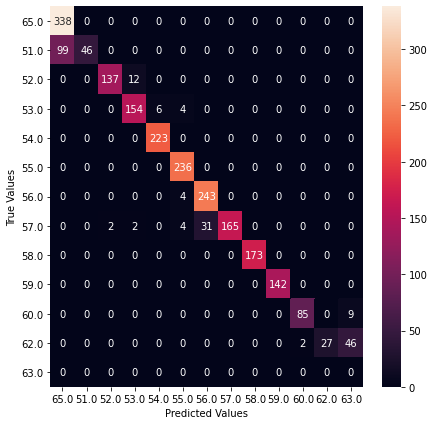

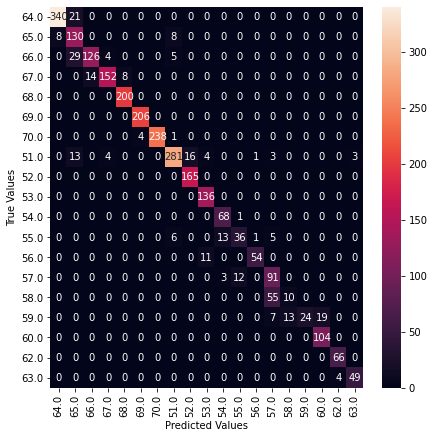

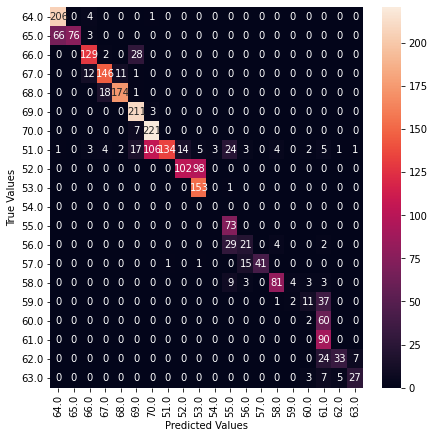

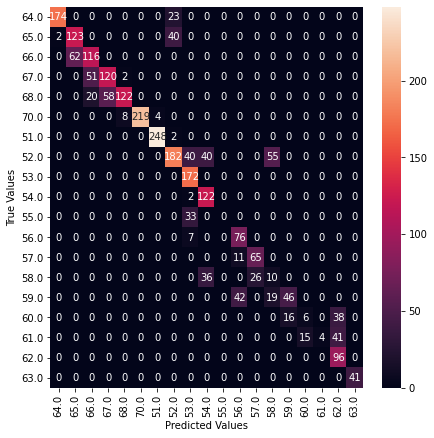

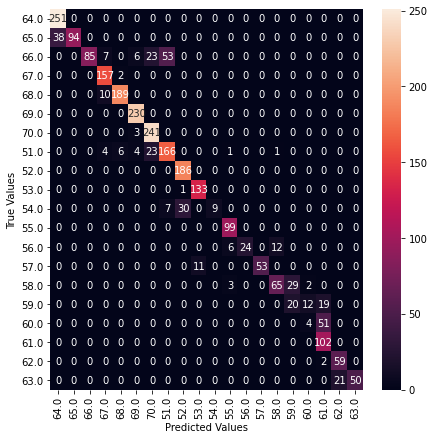

In [151]:
for y_true, y_pred in results:
    plot_cm(y_true, y_pred)

In [0]:
f1s_imei = {'f1':[], 'count':[]}
for i in range(len(imeis)):
  f1s_imei['f1'].append(f1_score(results[i][0],results[i][1],pos_label='positive',average='macro'))
  f1s_imei['count'].append(len(wifi_df[wifi_df['imei'] == imeis[i]]))

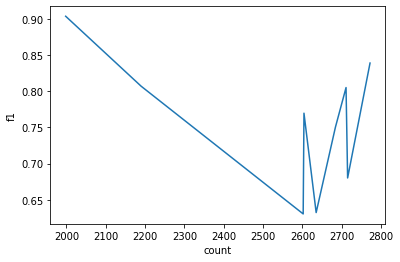

In [156]:
sns.lineplot(x = pd.DataFrame(f1s_imei)['count'], y = pd.DataFrame(f1s_imei)['f1'])

In [181]:
to_bar['num samples'].sum()

22911

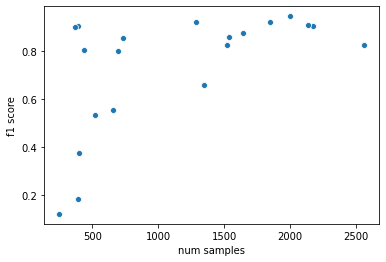

In [178]:
sns.scatterplot(x = to_bar['num samples'], y = to_bar['f1 score'], marker='o')

In [0]:
pres = pd.concat([pd.DataFrame(classification_report(results[i][0],results[i][1], output_dict=True)).transpose()['precision'] for i in range(len(imeis))], axis=1)
rec = pd.concat([pd.DataFrame(classification_report(results[i][0],results[i][1], output_dict=True)).transpose()['recall'] for i in range(len(imeis))], axis=1)
f1s = pd.concat([pd.DataFrame(classification_report(results[i][0],results[i][1], output_dict=True)).transpose()['f1-score'] for i in range(len(imeis))], axis=1)
sup = pd.concat([pd.DataFrame(classification_report(results[i][0],results[i][1], output_dict=True)).transpose()['support'] for i in range(len(imeis))], axis=1)

In [0]:
count_rooms = pd.DataFrame(scans_df.groupby('room_id').size())
count_rooms.reset_index(inplace=True)
count_rooms['room_id'] = count_rooms['room_id'].astype(str)
to_bar = pd.DataFrame(f1s.mean(axis=1)).reset_index()
to_bar = to_bar.merge(count_rooms, left_on='index', right_on='room_id')
to_bar.rename(columns={'0_x':'f1 score', '0_y':'num samples', 'index':'RoomId'}, inplace=True)

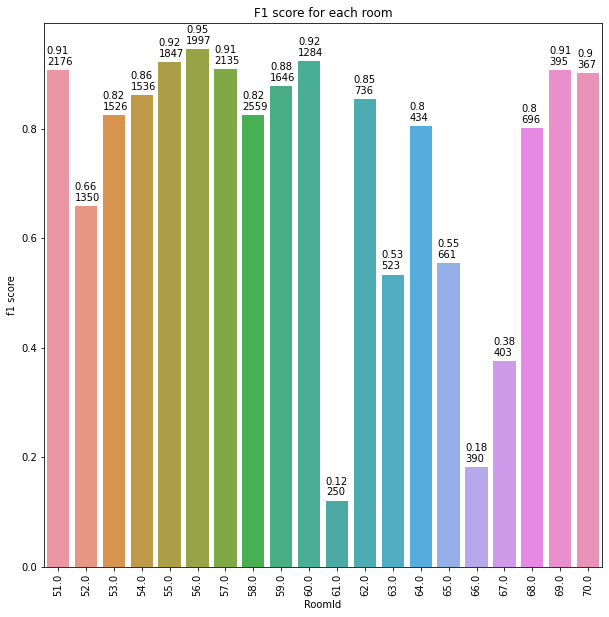

In [169]:
fig, ax = plt.subplots(figsize=(10, 10))
br = sns.barplot(x=to_bar['RoomId'], y=to_bar['f1 score'])
plt.title('F1 score for each room')
ax.set_xticklabels(rotation=90, labels=to_bar['RoomId'])
for i, p in enumerate(ax.patches):
  ax.annotate(to_bar['num samples'].iloc[i], (p.get_x(), p.get_height()+0.01))
  ax.annotate(round(to_bar['f1 score'].iloc[i], 2), (p.get_x(), p.get_height()+0.03))

In [0]:
classes = scans_df['room_id'].unique()
f1s = {}
for i in range(len(imeis)):
  f1s[imei] = []
  for c in classes:
    f1s[imei].append(f1_score(results[i][0],results[i][1],pos_label='positive',average='macro', target))
  f1s['f1'].append(f1_score(results[i][0],results[i][1],pos_label='positive',average='macro'))
  f1s['count'].append(len(wifi_df[wifi_df['imei'] == imeis[i]]))

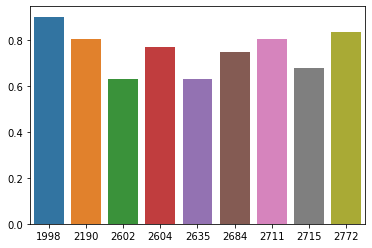

In [69]:
sns.barplot(x = f1s['count'], y  = f1s['f1'])

In [62]:
# No grid search, With N_SCANS
date_time = datetime.now().strftime("%m%d%Y_%H%M%S")
for i in range(len(imeis)):
    print(f"f1 Score of {imeis[i]} : " + str(f1_score(results[i][0],results[i][1],pos_label='positive',average='macro'))+"\n")

f1 Score of 6a5c9cb42f6a70a : 0.8051450527611571

f1 Score of 7f8be5b0fba18340 : 0.9038110200951454

f1 Score of 87888aecf8b37f14 : 0.6800775130415663

f1 Score of 536b033fb2bafb79 : 0.750342977154555

f1 Score of 9308bd64741f2270 : 0.8069795529991525

f1 Score of ef3f50e69df5ed94 : 0.8390361051951284

f1 Score of 3549bf4f1277a712 : 0.630327655675754

f1 Score of 059a0413c81c9823 : 0.632202111888708

f1 Score of 504ffc12331cd426 : 0.7696782504833737



In [0]:
#write the results to log file in output dir

date_time = datetime.now().strftime("%m%d%Y_%H%M%S")
# f = open(path + "\\" + date_time + '_results.txt','w')
for i in range(len(imeis)):
#     f.write(f"Prediction results for phone : {imeis[i]} \n\n")
#     f.write(classification_report(results[i][0],results[i][1]))
#     f.write(f" \n Confusion matrix : \n")
#     f.write(str(confusion_matrix(results[i][0],results[i][1]))+"\n\n")
#     f.write("Accuracy Score : " + str(accuracy_score(results[i][0],results[i][1]))+"\n")
#     f.write("f1 Score : " + str(f1_score(results[i][0],results[i][1],pos_label='positive',average='macro'))+"\n")
#     f.write("MCC Score : " + str(matthews_corrcoef(results[i][0],results[i][1]))+"\n")
#     f.write("\n______________________________________________________\n\n")
    print(f"f1 Score of {imeis[i]} : " + str(f1_score(results[i][0],results[i][1],pos_label='positive',average='macro'))+"\n")
# f.close()

f1 Score of 03ae308bd7102024 : 0.7117036816807603

f1 Score of 2c0522a1c69b22bc : 0.7518469606961641

f1 Score of 87888aecf8b37f14 : 0.8361858187838327

f1 Score of d2e242e0a080f7e7 : 0.8757805350559918

f1 Score of ef3f50e69df5ed94 : 0.874533933096751



##  T_SNE Checks

In [0]:
X = scans_df.drop(columns = fields_to_drop).fillna(fillna_rssi)
y = scans_df['room_id']
X_tsne = TSNE(n_components=2).fit_transform(X)

In [0]:
aparts = y.apply(lambda x:str(x)[0])

In [0]:
tsne_df = pd.DataFrame(X_tsne).rename(columns={0:'first', 1:'second'})
tsne_df['apart'] = aparts
tsne_df['room_id'] = y
tsne_df['imei'] = scans_df['imei']

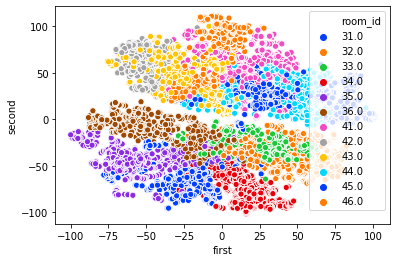

In [0]:
sns.scatterplot(x=tsne_df['first'], y=tsne_df['second'], hue=y, palette='bright')

Text(0.5, 1.0, 'T_SNE- Dimensionality Reduction \n Routers data only \n Apartmant No 2')

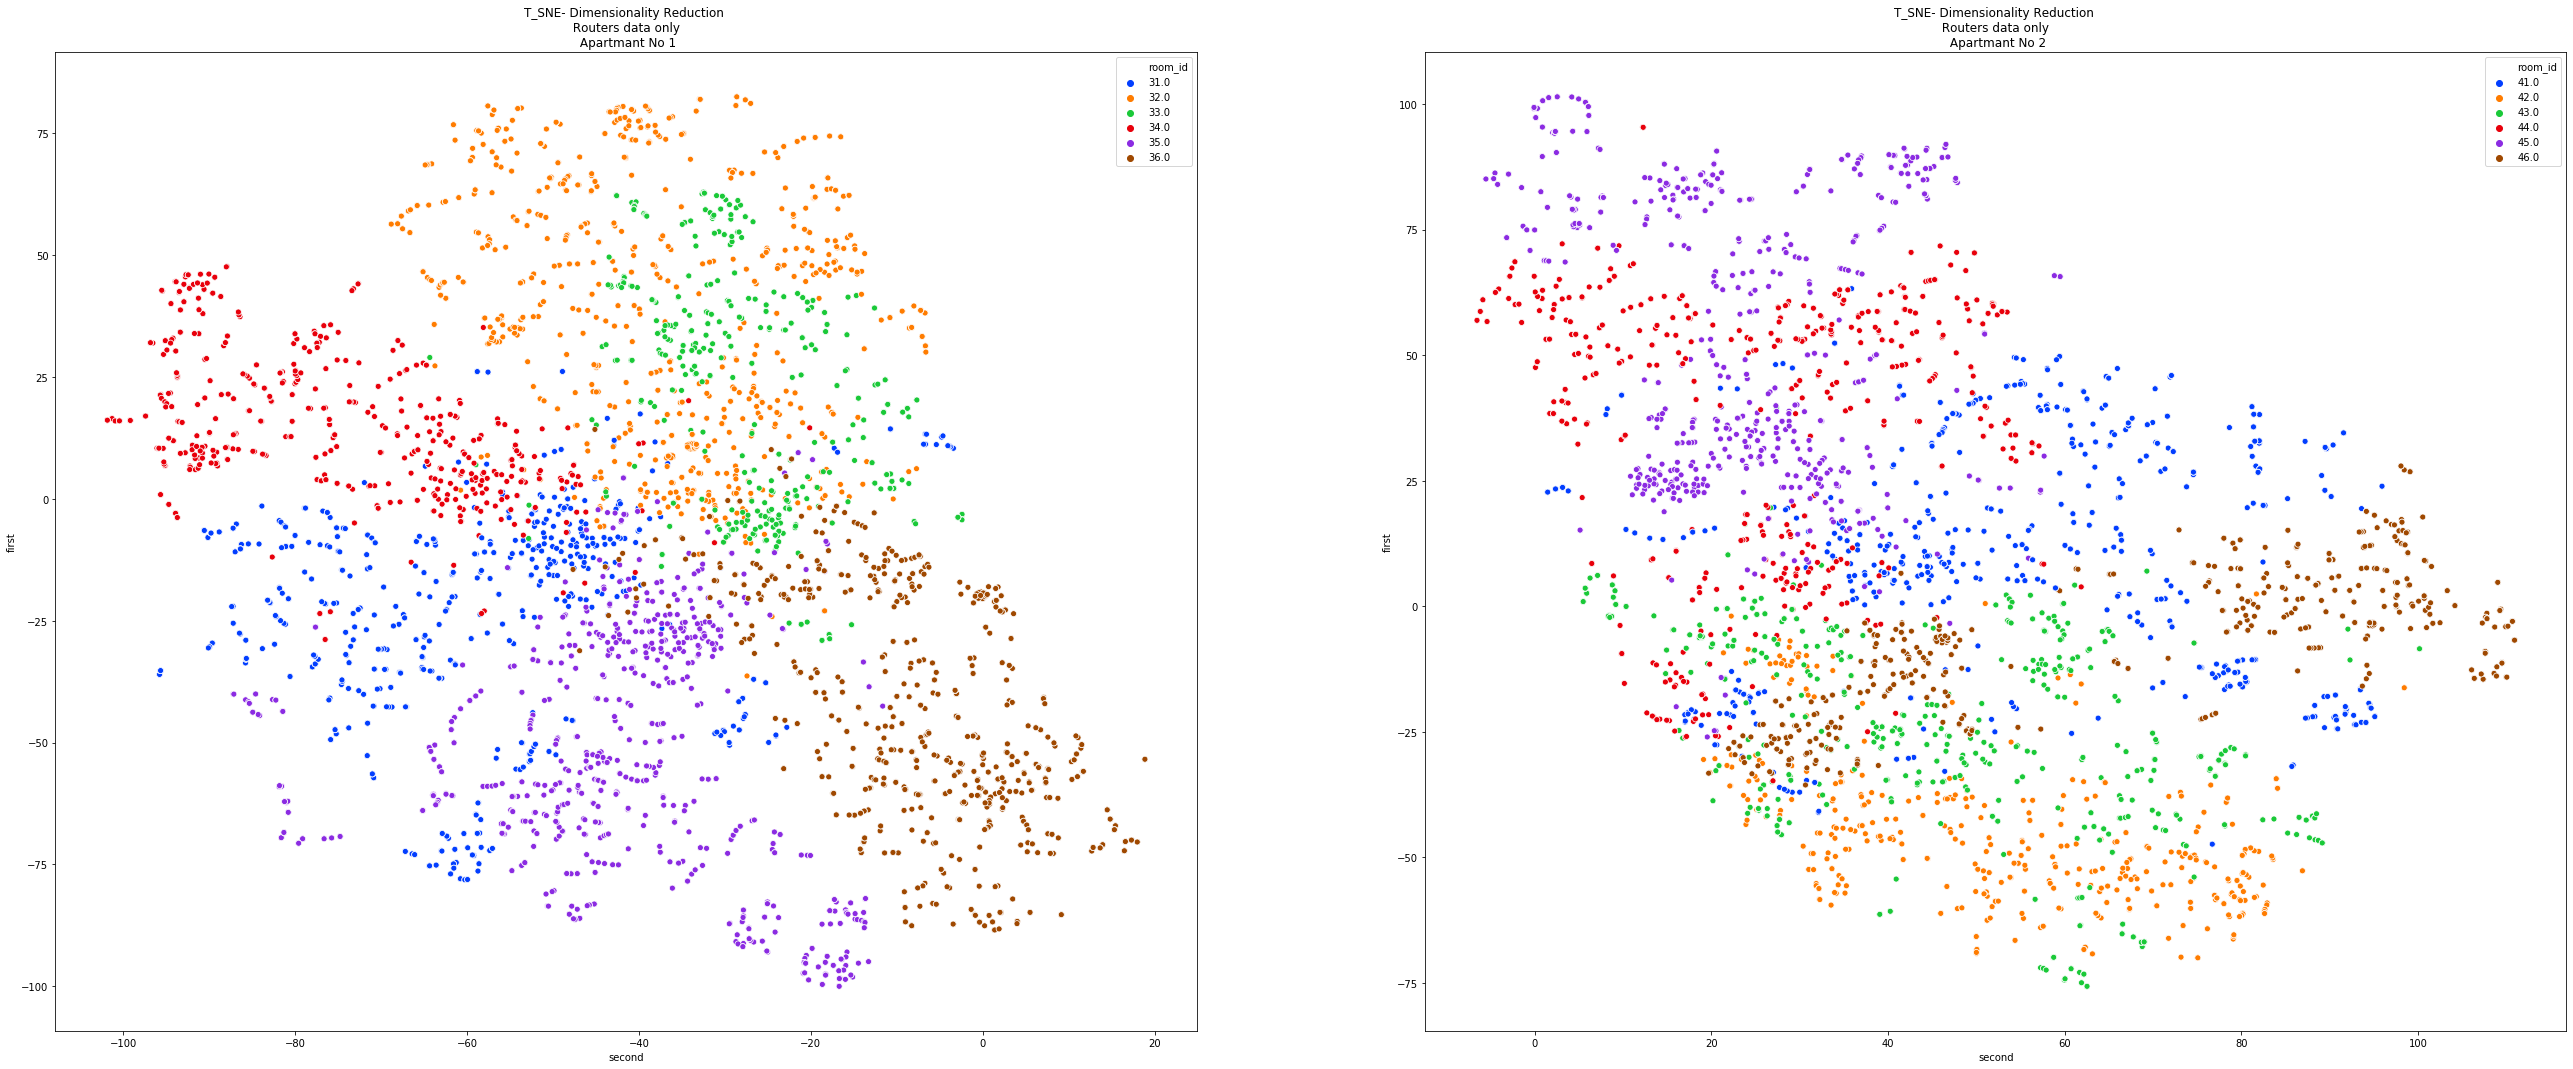

In [0]:
plt.figure(figsize=(45, 45))
plt.subplots_adjust(wspace = 0.2 , hspace = 0.5)

plt.subplot(2,2,1)
tsne_apart = tsne_df[tsne_df['apart'] == '3']
sns.scatterplot(x=tsne_apart['second'], y=tsne_apart['first'], hue=tsne_apart['room_id'], palette='bright')
plt.title('T_SNE- Dimensionality Reduction \n Routers data only \n Apartmant No 1')

plt.subplot(2,2,2)
tsne_apart = tsne_df[tsne_df['apart'] == '4']
sns.scatterplot(x=tsne_apart['second'], y=tsne_apart['first'], hue=tsne_apart['room_id'], palette='bright')
plt.title('T_SNE- Dimensionality Reduction \n Routers data only \n Apartmant No 2')

In [0]:
#results list
t_sne_models = {}
t_sne_results = []

nan_fill_value = -200

for imei in imeis:
    start = time.time()
    #train test split by imei:
    train = tsne_df[tsne_df['imei']!=imei]
    test = tsne_df[tsne_df['imei']==imei]

    X_train = train[['second', 'first']].fillna(fillna_rssi)
    X_test = test[['second', 'first']].fillna(fillna_rssi)
    y_train = train['room_id']
    y_test = test['room_id']
    
    rf_cv.fit(X_train, y_train)
    rf_best_model = rf_cv.best_estimator_
    y_pred = rf_best_model.predict(X_test)
    
    #add the result to list
    t_sne_models[imei] = {'X_train':X_train, 'X_test':X_test, 'y_train':y_train,'y_test':y_test, 'y_pred':y_pred, 'model':rf_best_model}
    t_sne_results.append([y_test, y_pred])
    print(time.time()-start)


62.99442648887634
75.16096425056458
76.14988899230957
76.76459002494812
73.50352597236633


In [0]:
for result in t_sne_results:
    print('fi score', f1_score(result[0],result[1],pos_label='positive',average='macro'))

fi score 0.4816302035237218
fi score 0.6356681278945939
fi score 0.5670508133666962
fi score 0.6975924145674396
fi score 0.6931446774265422


##  PCA Checks

In [0]:
X = scans_df.drop(columns = fields_to_drop).fillna(fillna_rssi)
y = scans_df['room_id']
aparts = y.apply(lambda x:str(x)[0])

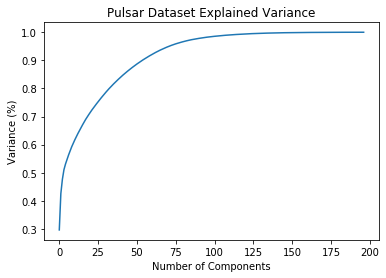

In [0]:
#Plotting the Cumulative Summation of the Explained Variance
pca = PCA().fit(X)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [0]:
pca = PCA(n_components=100).fit(X)

In [0]:
x_pca =pca.transform(X)

pca_df = pd.DataFrame(x_pca)
pca_df['apart'] = aparts
pca_df['room_id'] = y
pca_df['imei'] = scans_df['imei']

In [0]:
#results list
pca_models = {}
pca_results = []

nan_fill_value = -200

for imei in imeis:
    start = time.time()
    #train test split by imei:
    train = pca_df[pca_df['imei']!=imei]
    test = pca_df[pca_df['imei']==imei]
    
    X_train = train.drop(columns=['apart', 'room_id', 'imei']).fillna(fillna_rssi)
    X_test = test.drop(columns=['apart', 'room_id', 'imei']).fillna(fillna_rssi)
    y_train = train['room_id']
    y_test = test['room_id']
    
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    #add the result to list
    pca_models[imei] = {'X_train':X_train, 'X_test':X_test, 'y_train':y_train,'y_test':y_test, 'y_pred':y_pred, 'model':rf_best_model}
    pca_results.append([y_test, y_pred])
    print(time.time()-start)


7.235243558883667
8.646535158157349
9.334283828735352
7.960007190704346
7.6199469566345215


In [0]:
for result in pca_results:
    print('fi score', f1_score(result[0],result[1],pos_label='positive',average='macro'))

fi score 0.6533808989046889
fi score 0.6643791285237555
fi score 0.6871909520760386
fi score 0.6763267842637002
fi score 0.7968861117679403


In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X)
X_pca =pca.transform(X)
aparts = y.apply(lambda x:str(x)[0])

pca_df = pd.DataFrame(X_pca).rename(columns={0:'first', 1:'second'})
pca_df['apart'] = aparts
pca_df['room_id'] = y

Text(0.5, 1.0, 'PCA- Dimensionality Reduction \n Routers data only')

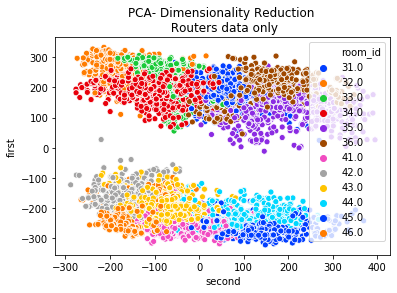

In [0]:
#PCA without timestamps
sns.scatterplot(x=pca_df['second'], y=pca_df['first'], hue=pca_df['room_id'], palette='bright')
plt.title('PCA- Dimensionality Reduction \n Routers data only')

Text(0.5, 1.0, 'PCA- Dimensionality Reduction \n Routers data only')

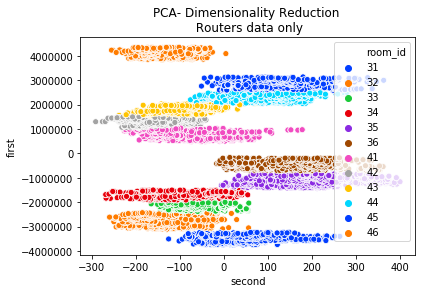

In [0]:
#PCA with timestamps
sns.scatterplot(x=pca_df['second'], y=pca_df['first'], hue=pca_df['room_id'], palette='bright')
plt.title('PCA- Dimensionality Reduction \n Routers data only')

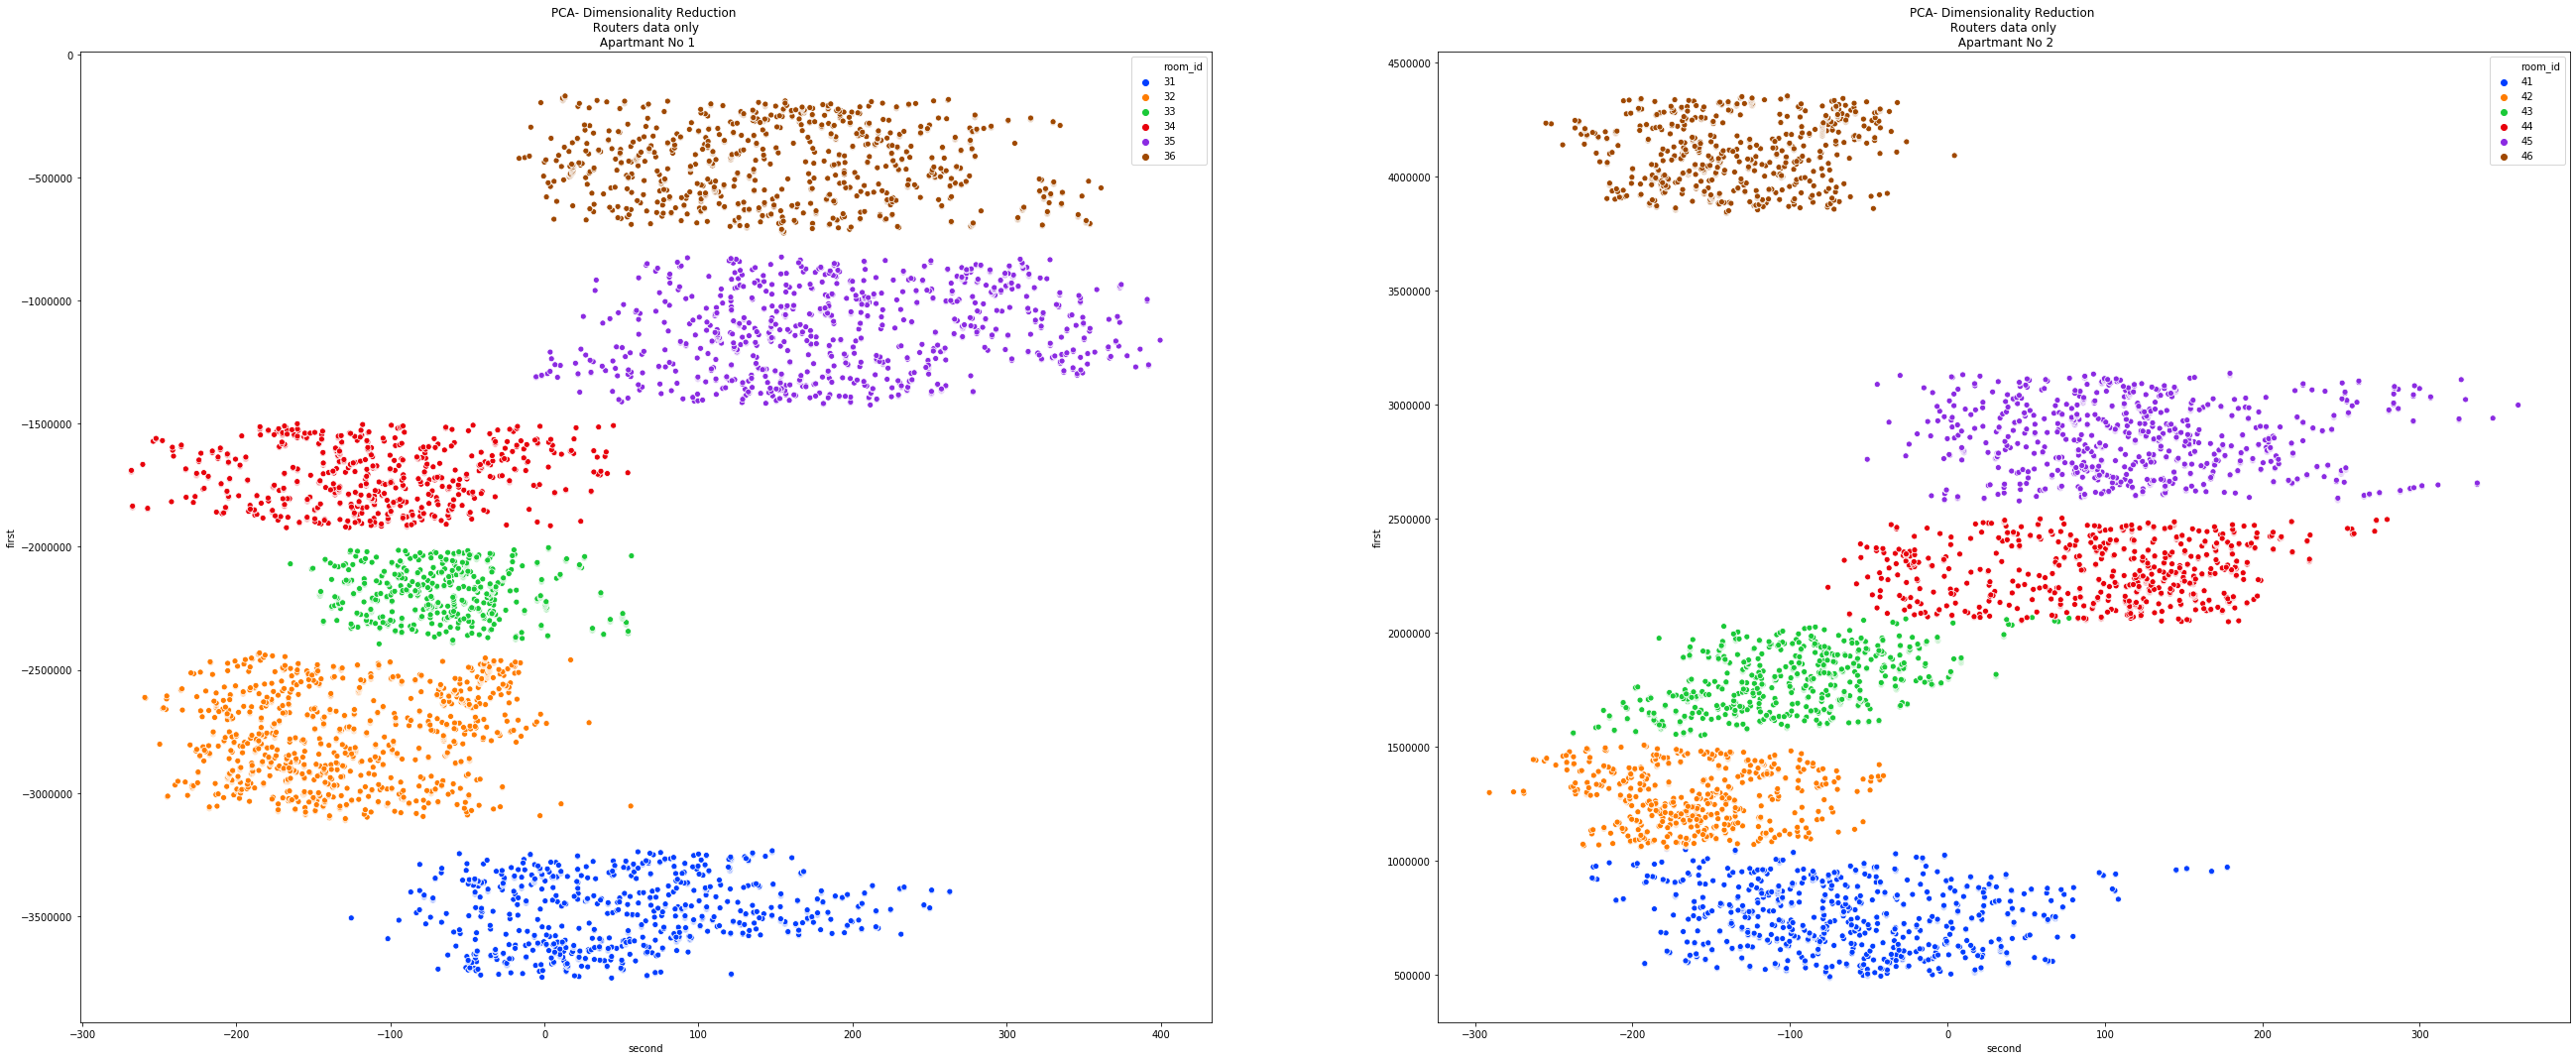

In [0]:
plt.figure(figsize=(45, 45))
plt.subplots_adjust(wspace = 0.2 , hspace = 0.5)

plt.subplot(2,2,1)
plt.title('PCA- Dimensionality Reduction \n Routers data only \n Apartmant No 1')
pca_apart = pca_df[pca_df['apart'] == '3']
sns.scatterplot(x=pca_apart['second'], y=pca_apart['first'], hue=pca_apart['room_id'], palette='bright')

plt.subplot(2,2,2)
plt.title('PCA- Dimensionality Reduction \n Routers data only \n Apartmant No 2')
pca_apart = pca_df[pca_df['apart'] == '4']
sns.scatterplot(x=pca_apart['second'], y=pca_apart['first'], hue=pca_apart['room_id'], palette='bright')


In [0]:
from sklearn.cluster import KMeans

In [0]:
km = KMeans(n_clusters=6)
km.fit(pca_apart[['second', 'first']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

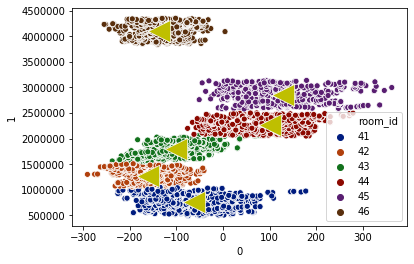

In [0]:
sns.scatterplot(x=pca_apart['second'], y=pca_apart['first'], hue=pca_apart['room_id'], palette='dark')
sns.scatterplot(x=pd.DataFrame(km.cluster_centers_)[0], y=pd.DataFrame(km.cluster_centers_)[1], color='y', s=500, marker='<')

In [0]:
out_clusters = pd.DataFrame({'y_pred':km.labels_, 'y_true':pca_apart['room_id']})

In [0]:
replace = {0:45, 1:42, 2:44, 3:46, 4:41, 5:43}

out_clusters.y_pred.replace(replace, inplace=True)

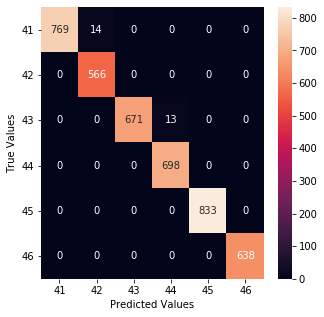

In [0]:
plot_cm(out_clusters['y_true'], out_clusters['y_pred'], figsize=5)

##  Check Unsupervised

In [0]:
X = scans_df.drop(fields_to_drop, axis=1).fillna(fillna_rssi)
y = scans_df['room_id']

In [0]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [0]:
dbs_runs = pd.DataFrame(X_scaled.copy())

In [0]:
pca = PCA(n_components=2).fit(X_scaled)
X_pca =pca.transform(X_scaled)
aparts = y.apply(lambda x:str(x)[0])

pca_df = pd.DataFrame(X_pca).rename(columns={0:'first', 1:'second'})
pca_df['apart'] = aparts
pca_df['room_id'] = y

Text(0.5, 1.0, 'PCA- Dimensionality Reduction \n Routers data only')

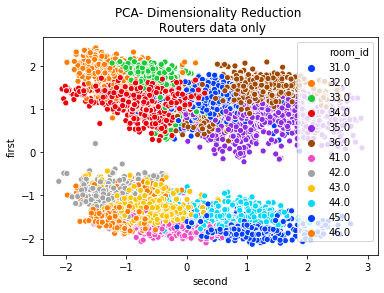

In [0]:
sns.scatterplot(x=pca_df['second'], y=pca_df['first'], hue=pca_df['room_id'], palette='bright')
plt.title('PCA- Dimensionality Reduction \n Routers data only')

In [0]:
dbs = DBSCAN().fit(X_scaled)

In [0]:
dbs_runs['run_1'] = dbs.labels_

In [0]:
dbs = DBSCAN(min_samples=3).fit(X_scaled)

In [0]:
dbs_runs['run_2'] = dbs.labels_

Text(0.5, 1.0, 'PCA- Dimensionality Reduction \n Routers data only')

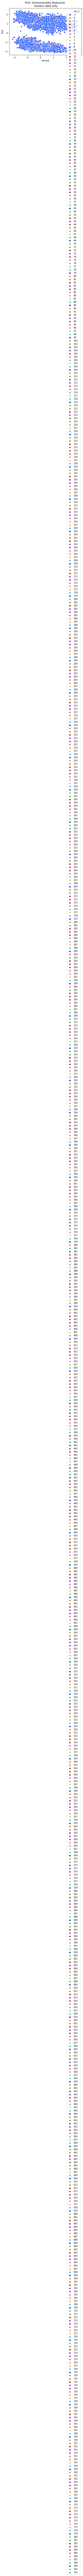

In [0]:
sns.scatterplot(x=pca_df['second'], y=pca_df['first'], hue=dbs_runs['run_2'], palette='bright')
plt.title('PCA- Dimensionality Reduction \n Routers data only')

##  New Data Check

In [0]:
new_folder_path = r'C:\Users\tal\Desktop\tamar\HospiTrack-master\Datasets\Saturday'
new_wifi_df = read_folder_to_wifi_df(new_folder_path)

In [0]:
imeis_to_check = new_df.imei.unique()
scans_df_no_imeis = scans_df[~scans_df['imei'].isin(imeis_to_check)]
rf_cv.fit(scans_df_no_imeis.drop(fields_to_drop,axis=1).fillna(fillna_rssi), scans_df_no_imeis['room_id'])
rf_best_model = rf_cv.best_estimator_
rf_best_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [0]:
new_wifi_df = preproccess(new_wifi_df)

TypeError: preproccess() missing 1 required positional argument: 'starting_date'

In [0]:
new_scans_df = create_scans_df(new_wifi_df)

In [0]:
features_to_add = np.setdiff1d()
features_to_drop =

In [0]:
X_new = X_new[np.intersect1d(X_new.columns, scans_df.columns)]
print(X_new.shape)

(620, 91)


In [0]:
print(X_new.shape)
X_new = pd.concat([scans_df,X_new]).iloc[len(scans_df):]
print(X_new.shape)

(620, 91)
(620, 201)


In [0]:
X_new.head(2)

,40:9b:cd:ca:f1:7c,14:ae:db:36:68:6d,00:68:eb:17:2d:35,04:f0:21:41:db:76,14:ae:db:54:2c:f5,40:9b:cd:ca:56:68,10:be:f5:3c:29:f6,b4:ee:b4:fe:21:fb,ec:9a:74:98:3c:9d,00:b8:c2:50:4f:21,...,8c:59:c3:bb:95:5c,a0:ab:1b:55:55:ee,12:13:31:c7:df:e3,10:5a:f7:1e:95:50,c4:12:f5:fd:ee:7c,60:e3:27:e8:3e:88,room_id,imei,timestamp,n_scans
0,NaN,-82.0,NaN,NaN,-75.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,41.0,ef3f50e69df5ed94,1586029684195,NaN
1,NaN,-86.0,NaN,NaN,-82.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,41.0,ef3f50e69df5ed94,1586029687205,NaN


In [0]:
y_pred_new = rf_best_model.predict(X_new.drop(fields_to_drop,axis=1).fillna(nan_fill_value))


date_time = datetime.now().strftime("%m%d%Y_%H%M%S")
# f = open(path + "\\" + date_time + '_new_results.txt','w')
# f.write(classification_report(new_df['room_id'], y_pred_new))
# f.write(f" \n Confusion matrix : \n")
# f.write(str(confusion_matrix(new_df['room_id'], y_pred_new))+"\n\n")
# f.write("Accuracy Score : " + str(accuracy_score(new_df['room_id'], y_pred_new))+"\n")
# f.write("f1 Score : " + str(f1_score(new_df['room_id'], y_pred_new,pos_label='positive',average='macro'))+"\n")
# f.write("MCC Score : " + str(matthews_corrcoef(new_df['room_id'], y_pred_new))+"\n")
# f.write("\n______________________________________________________\n\n")
print(f"f1 Score  : " + str(f1_score(new_df['room_id'], y_pred_new,pos_label='positive',average='macro'))+"\n")
# f.close()

f1 Score  : 0.7691758017980735



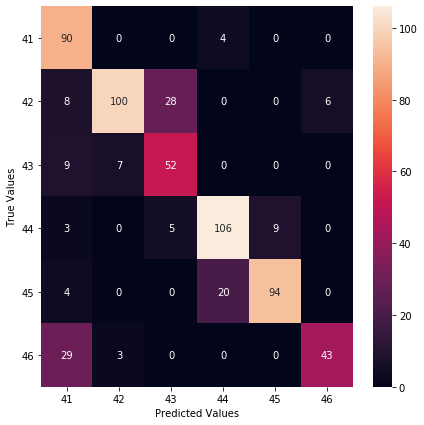

In [0]:
plot_cm(new_df['room_id'], y_pred_new)

In [0]:
# import shap
# shap.initjs()
# explainer = shap.TreeExplainer(rf_best_model)
# shap_values = explainer.shap_values(X_train)
# shap.summary_plot(shap_values, X_train, class_names=scans_df.room_id.unique())

### Create output folder and figures

In [0]:
date_time = datetime.now().strftime("%m%d%Y_%H%M%S")
path = date_time + '_output_folder'
os.mkdir(path) #new output folder in main dir

Number of WiFi scans per sample : 
count    8906.000000
mean       20.928812
std         7.236262
min         4.000000
25%        16.000000
50%        20.000000
75%        25.000000
max        56.000000
Name: n_scans, dtype: float64


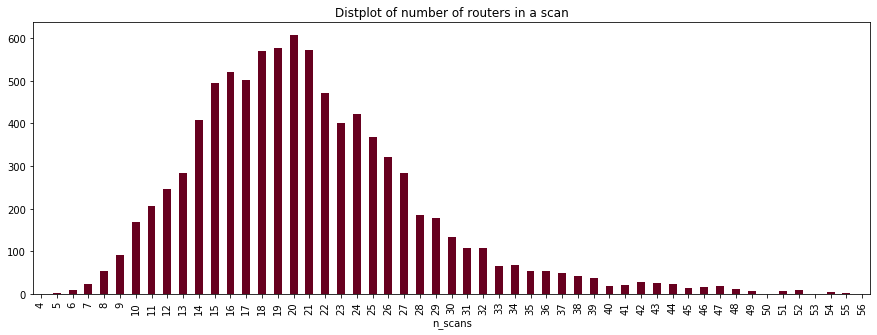

In [0]:
plt.figure(figsize=(15, 5))
#count only scans (not nan)
scans_df['n_scans'] = scans_df.apply(lambda x: x.count()-2, axis=1)  # (-2) for columns 'room_id' and 'imei' in scans_df

print('Number of WiFi scans per sample : ')
print(scans_df['n_scans'].describe())
scans_df.groupby('n_scans').size().plot(kind='bar', stacked=True, colormap='RdBu')#.bar(colo)
plt.title('Distplot of number of routers in a scan')
plt.savefig(path+"\\n_scans.jpg")

In [0]:
scans_df['apart'] = scans_df.room_id.apply(lambda x:str(x)[0])

In [0]:
new = pd.DataFrame(scans_df.groupby(['apart', 'imei']).size()).reset_index()

In [0]:
new['apart'].replace({'3':'apartment 1', '4':'apartment 2'})

0    apartment 1
1    apartment 1
2    apartment 1
3    apartment 1
4    apartment 1
5    apartment 2
6    apartment 2
7    apartment 2
8    apartment 2
9    apartment 2
Name: apart, dtype: object

Text(0.5, 1.0, 'Number of Samples per imei for each apartment')

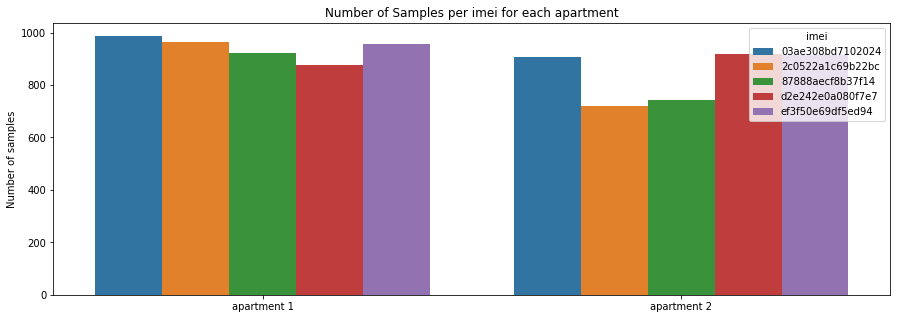

In [0]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=new['apart'].replace({'3':'apartment 1', '4':'apartment 2'}), y=new[0], hue=new['imei'])
ax.set(ylabel='Number of samples', xlabel='')
plt.title('Number of Samples per imei for each apartment')

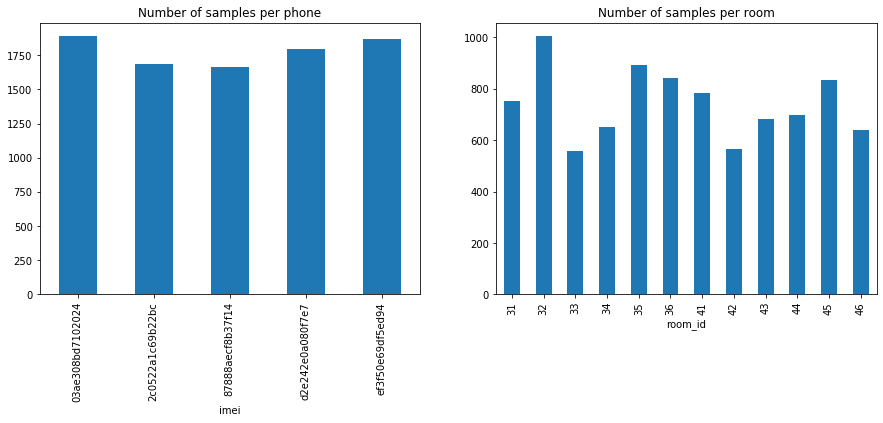

In [0]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.title('Number of samples per phone')
scans_df.groupby('imei').size().plot.bar()
plt.subplot(1,2,2)
plt.title('Number of samples per room')
scans_df.groupby('room_id').size().plot.bar()
plt.savefig(path+"\\samples_per_phone_and_room.jpg")

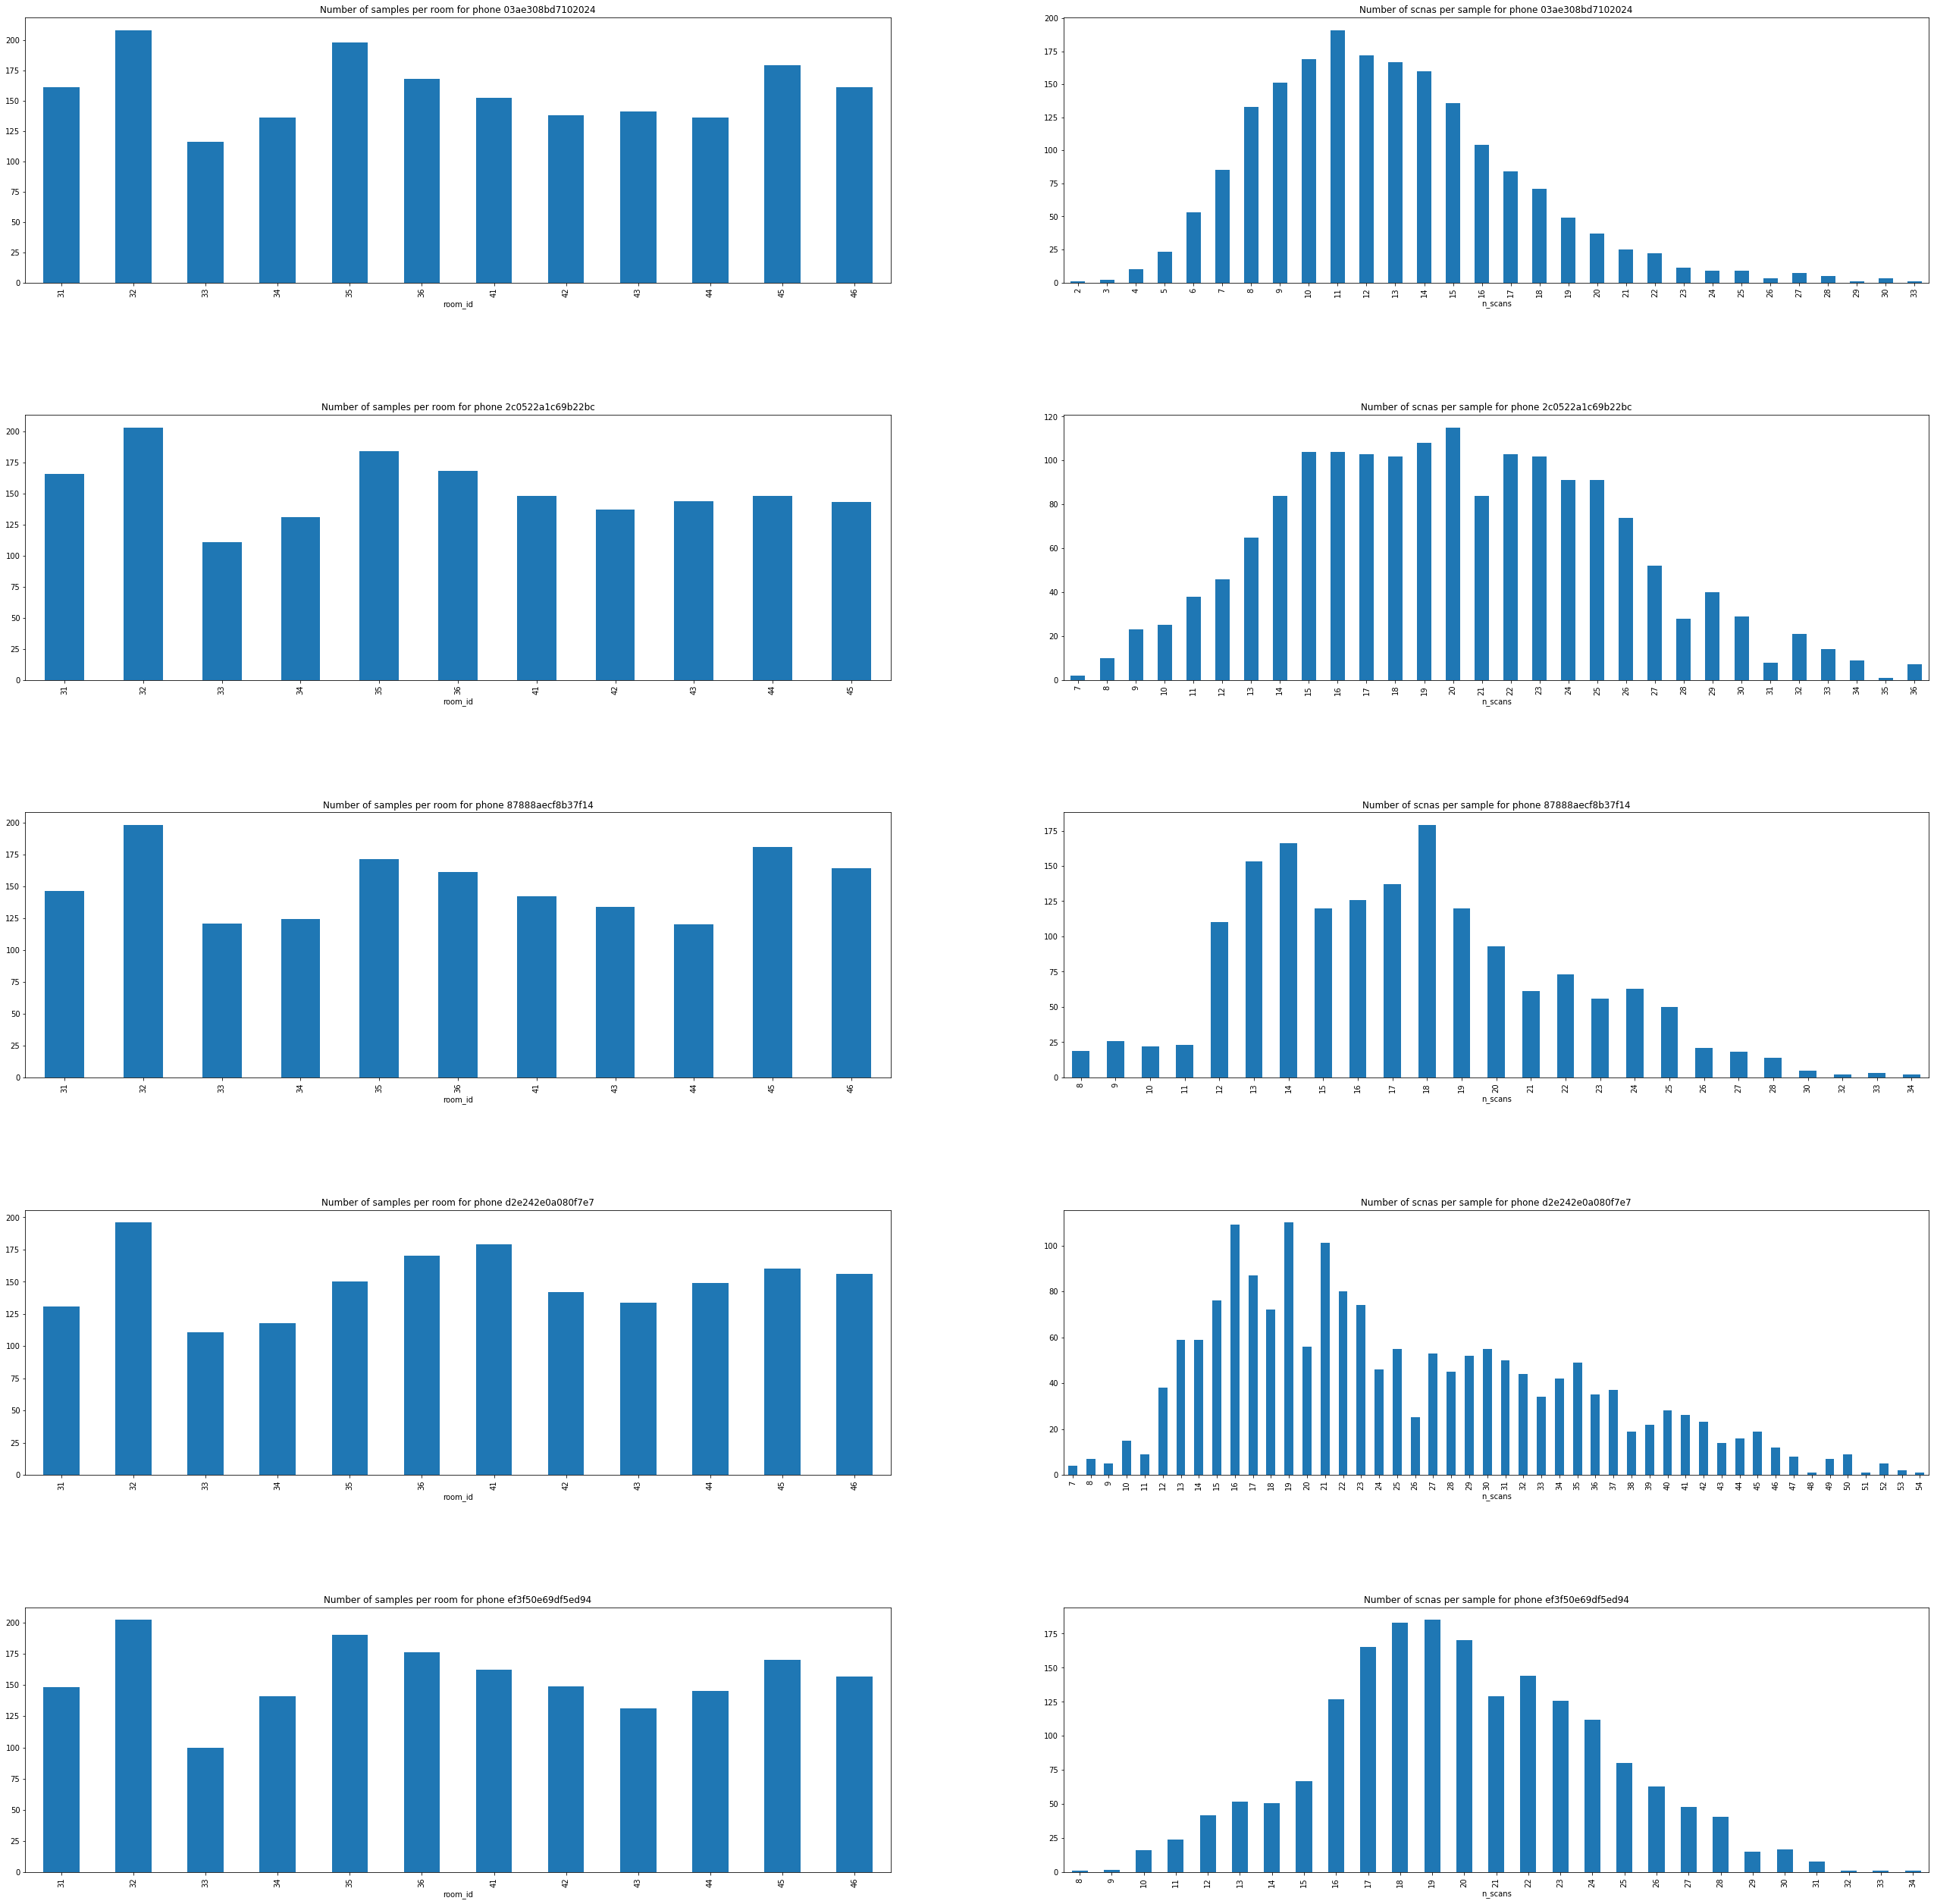

In [0]:
plt.figure(figsize=(45, 45))
plt.subplots_adjust(wspace = 0.2 , hspace = 0.5)

i=1
for imei in imeis:
    plt.subplot(len(imeis),2,i)
    plt.title(f'Number of samples per room for phone {imei}')
    scans_df[scans_df['imei']==imei].groupby('room_id').size().plot.bar()
    plt.subplot(len(imeis),2,i+1)
    plt.title(f'Number of scnas per sample for phone {imei}')
    scans_df[scans_df['imei']==imei].groupby('n_scans').size().plot.bar()
    i+=2
plt.savefig(path+"\\scans_and_smaple_per_room_for_each_phone.jpg")